In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade openai pillow opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.5/725.5 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.82.1
    Uninstalling openai-1.82.1:
      Successfully uninstalled openai-1.82.1


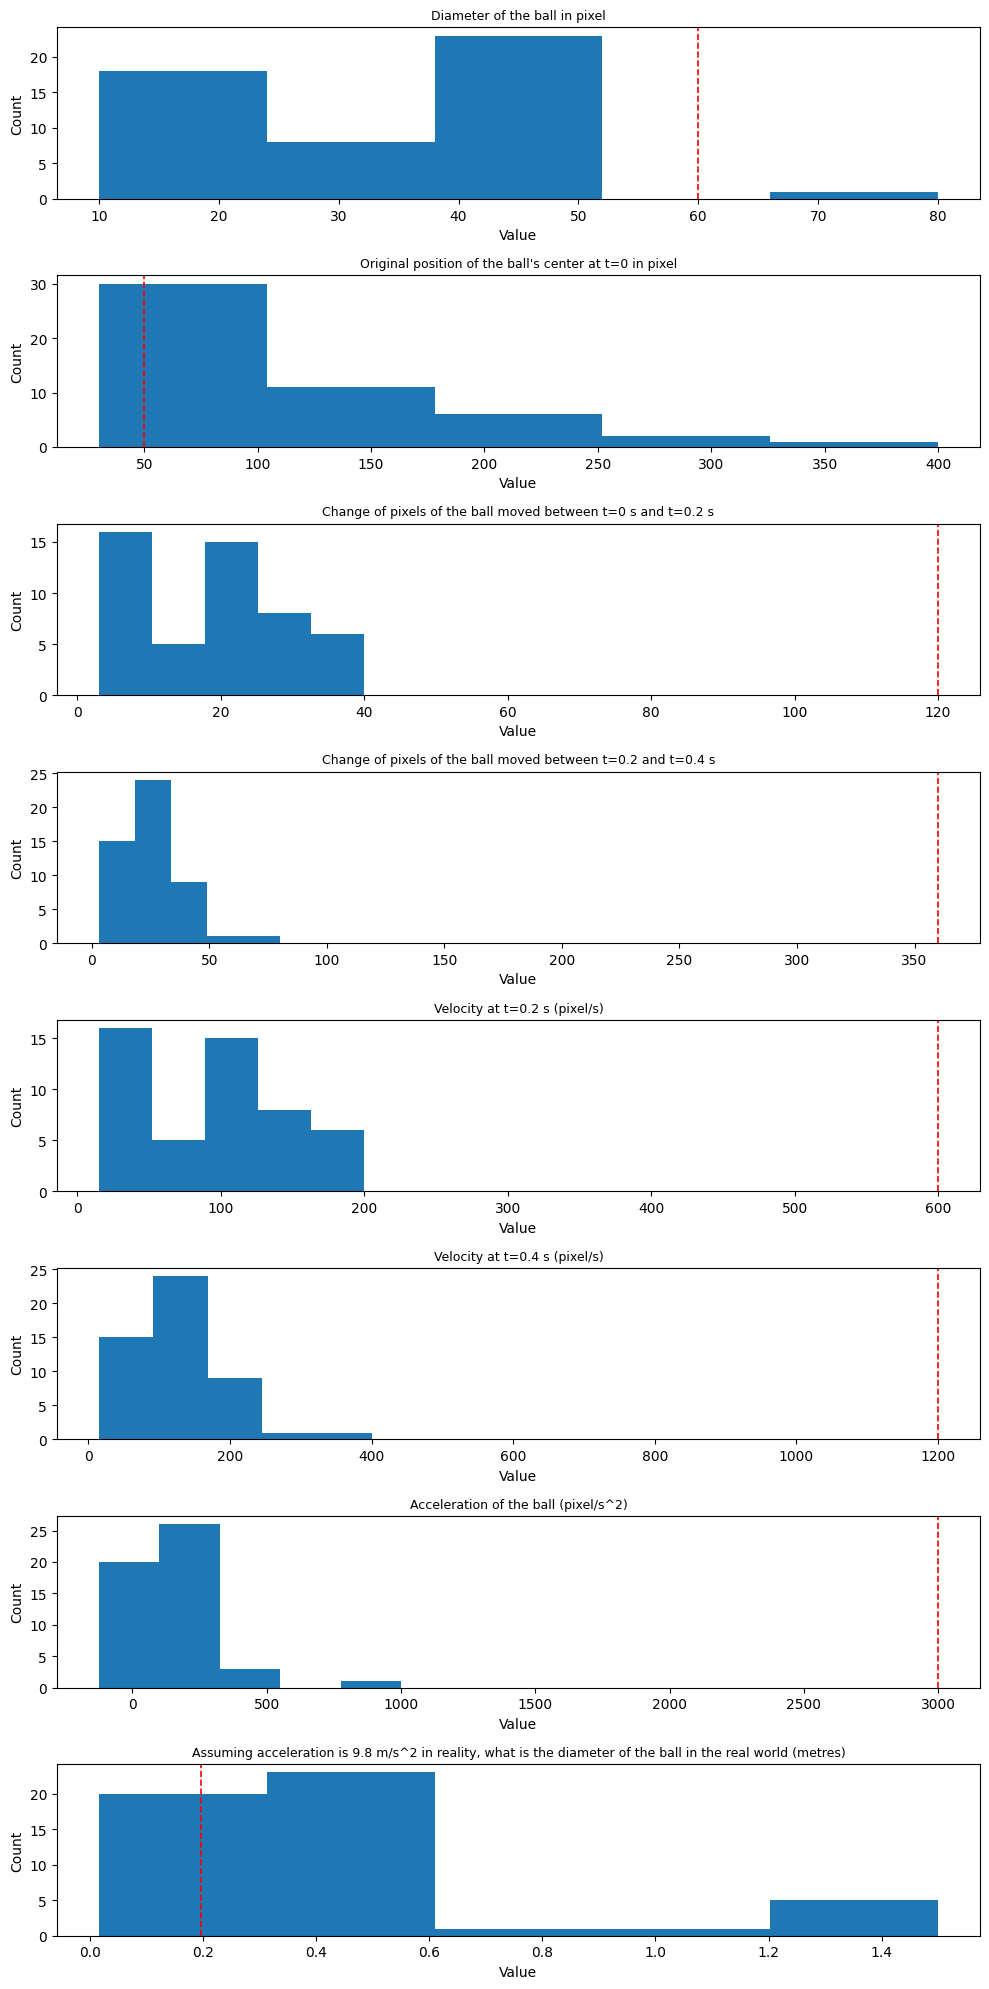

In [ ]:
import cv2, base64, textwrap, numpy as np, matplotlib.pyplot as plt, pandas as pd
from collections import defaultdict
import re
from openai import OpenAI

client = OpenAI(
  api_key="api_key"
)

video_dir = "/content/drive/MyDrive/CS_project/CS231/Videos/red_ball_variation"
video_name = "BG_INDISTINGUISHABLE_(250, 5, 5)"
video_path = (video_dir+video_name+".mp4")
output_dir = "/content/drive/MyDrive/CS_project/CS231/Videos/output/"

metrics = [
    "Diameter of the ball in pixel",
    "Original position of the ball's center at t=0 in pixel",
    "Change of pixels of the ball moved between t=0 s and t=0.2 s",
    "Change of pixels of the ball moved between t=0.2 and t=0.4 s",
    "Velocity at t=0.2 s (pixel/s)",
    "Velocity at t=0.4 s (pixel/s)",
    "Acceleration of the ball (pixel/s^2)",
    "Assuming acceleration is 9.8 m/s^2 in reality, what is the diameter of the ball in the real world (metres)",
]

target_values = [60, 50, 120, 360, 600, 1200, 3000, 0.196]
# target_values = [60, 50, 720, 720, 1200, 2400, 6000, 0.098]
# target_values = [120,50,120,360,600,1200,3000,0.392]
# target_values = [70, 50,392,1176,1960,3920,9800,0.07] #tennis
# target_values = [130,90,392,1176,1960,3920,9800,0.13] #winnie

# --------- PARSER ---------
number_re = re.compile(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)")
def parse_number(text: str) -> float:
    seg = text.split("=>", 1)[-1]
    m = number_re.search(seg)
    return float(m.group(0)) if m else np.nan

# --------- FRAME SAMPLING ---------
def sample_frames(path, step_s=0.2, cap_frames=60):
    cap  = cv2.VideoCapture(path)
    fps  = cap.get(cv2.CAP_PROP_FPS) or 25
    step = int(round(fps * step_s))
    imgs = []
    i = 0
    while len(imgs) < cap_frames and cap.isOpened():
        ok, frame = cap.read()
        if not ok: break
        if i % step == 0:
            _, buf = cv2.imencode(".jpg", frame)
            b64 = base64.b64encode(buf).decode()
            imgs.append({"type": "image_url",
                         "image_url": {"url": f"data:image/jpeg;base64,{b64}"}})
        i += 1
    cap.release()
    return imgs

frames = sample_frames(video_path)

# --------- PROMPT ---------
one_shot_messages = [
    {
        "role": "system",
        "content": (
            "Return a single line of comma-separated pairs like:\n"
            "Metric <k> => <number>\n"
            "where <k> is the index of the question (1-based) and <number> is a\n"
            "decimal-point value. Do not write the metric’s real name, units, or\n"
            "any extra words.\n"
            "Pixel units unless the question says metres.\n"
        ),
    },
    {
        "role": "user",
        "content": frames + [{
            "type": "text",
            "text": textwrap.dedent(
                "Answer the following questions *in this exact order*: \n• " +
                "\n• ".join(metrics) +
                "\n\nFormat: Metric => number, Metric => number, …"
            )
        }],
    },
]

# --------- RUN PROMPT ---------
one_shot_vals = defaultdict(list)

for run in range(50):  # Adjust runs
    one_resp = client.chat.completions.create(
        model="gpt-4o",
        messages=one_shot_messages,
        max_tokens=120,
    ).choices[0].message.content

    for pair in one_resp.split(","):
        if "=>" not in pair:
            continue
        met_id, valtxt = pair.split("=>", 1)
        try:
            k = int(re.search(r"\d+", met_id).group(0)) - 1
            one_shot_vals[metrics[k]].append(parse_number("=>" + valtxt))
        except:
            continue

# --------- SAVE TO CSV ---------
rows = []
for metric in metrics:
    for i, val in enumerate(one_shot_vals[metric], start=1):
        rows.append({
            "type": "oneshot",
            "metric_index": metrics.index(metric) + 1,
            "metric": metric,
            "run": i,
            "answer": val
        })

df = pd.DataFrame(rows, columns=["type", "metric_index", "metric", "run", "answer"])
df.to_csv(f"{output_dir}{video_name}_metric_results.csv", index=False)

# --------- PLOT ---------
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, len(metrics)*2.5))
for i, (met, target) in enumerate(zip(metrics, target_values)):
    vals = [v for v in one_shot_vals[met] if not np.isnan(v)]
    axs[i].hist(vals, bins=5)
    axs[i].axvline(target, color='red', linestyle='dashed', linewidth=1.2)
    axs[i].set_title(f"{met}", fontsize=9)
    axs[i].set_ylabel("Count")
    axs[i].set_xlabel("Value")

plt.tight_layout()
plt.savefig(f"{output_dir}{video_name}_oneshot_hist.png")
plt.show()


In [ ]:
# ---------- Summary Table ----------
summary = []

for metric in metrics:
    values = [v for v in one_shot_vals[metric] if not np.isnan(v)]
    mean = np.mean(values) if values else np.nan
    std = np.std(values, ddof=1) if len(values) > 1 else np.nan
    summary.append({
        "Metric Index": metrics.index(metric) + 1,
        "Mean": round(mean, 3),
        "Std Dev": round(std, 3)
    })

summary_df = pd.DataFrame(summary, columns=["Metric Index", "Mean", "Std Dev"])
print(summary_df.to_string(index=False))


 Metric Index    Mean  Std Dev
            1  34.148   17.411
            2 126.816   73.415
            3  19.422   11.119
            4  24.422   14.701
            5  97.110   55.594
            6 122.110   73.507
            7 128.240  185.318
            8   0.470    0.411
